In [1]:
import sys
sys.path.append('/home/mchoblet/paleoda')

import xarray as xr
import wrapper
import dataloader
import tqdm
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature  
from matplotlib.offsetbox import AnchoredText    
import utils

import copy

%load_ext autoreload
%autoreload 2

In [2]:
#paths to all models (downsampled to Echam resolution)
multi_prior_ds={
    'iHadCM3':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_prec_801_1952.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_tsurf_801_1952.nc',
'slp':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_slp_801_1952.nc',
       },
'iCESM':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc',
       },
'isoGSM':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc',
       },    
'Echam':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc',
       },
'GISS':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc',
'slp': '/home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc',
       },
}

#upsampled multiprior
multi_prior_up={
    'iHadCM3':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_d18O_801_1952.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_evap_801_1952.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_prec_801_1952.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_tsurf_801_1952.nc',
'slp':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_slp_801_1952.nc',
       },
'iCESM':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_d18O_850_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_evap_850_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_prec_850_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_tsurf_850_1850.nc',
       },
'isoGSM':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_d18O_851_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_evap_851_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_prec_851_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_tsurf_851_1850.nc',
       },    
'Echam':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_tsurf_850_1849.nc',
       },
'GISS':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/GISS_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/GISS_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/GISS_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/GISS_tsurf_850_1849.nc',
'slp': '/home/mchoblet/paleoda/data/model_data/upsampled/GISS_slp_850_1849.nc',
       },
}


paths={
'iCESM':{'d18O':'/home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc',
       },
'isoGSM':{'d18O':'/home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc',
       },    
'Echam':{'d18O':'/home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
       },
'GISS':{'d18O':'/home/mchoblet/paleoda/data/model_data/GISS_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/GISS_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc',
'slp': '/home/mchoblet/paleoda/data/model_data/GISS_slp_850_1849.nc',
       },
'iHadCM3':{'d18O':'/home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/iHADCM3_tsurf_801_1952.nc',
'slp':'/home/mchoblet/paleoda/data/model_data/iHADCM3_slp_801_1952.nc',
       }
} 

In [73]:
#CONFIG DICTIONARY (NEW)

#lists are sometimes necessary, especially if we use multiple proxy-DBs (e.g. SISAL and iso2k)
#and multiple timescales
cfg={
'vp':{
'd18O':'/home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc',
'tsurf': '/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
'evap': '/home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc',
'slp': None,
},
'avg':None,
'oro': '/home/mchoblet/paleoda/data/orographies/echam_oro.nc',
'reconstruct':['tsurf'],
#'reconstruct':['tsurf','d18O','prec'],
'basepath':'/home/mchoblet/paleoda/', #dont forget last slash
'output_folder':'thesis_5_5', #in cwd
'output_file':'Echam_realistic_PPE_snr1',
'multi_model_prior': None, #None or a list where the first entry is a dictionary of dictionaries for the file paths and secord a dictionary with the orography files
'avg':None, 
'seed': 42, 
'check_nan':False, #mainly needed for iHadCM3, because of its missing years nans are introduced with 'resampled'
'obsdata':['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc'],
'obs_var':[['d18O','d18O_precision'],['d18O','d18O_precision']],
'how_many': None, #use all 108/109 locations, that's easier.
'only_regional_proxies':False,
'regional_bounds':False,
'obs_var':[['d18O','d18O_precision'],['d18O','d18O_precision']], #name of variables and uncertainties in proxy_db files
'proxy_error': [0.1,0.1], #irrelevant for PPE
#irrelevant for PPE
'time_scales': ['median','median'],
'proxy_time':['0851','1849'],
#'time': ['0851','1849'], #das ist in allen modellen drin
'resample': True,
'resample_mode': 'nearest',
'mask': 3, 
###MULTI-TIMESCALE
#'timescales':[1,5,10,20], #list of timescales (have to be true divisors of longest timescale (block size)) Timescale 1 always required! 
'timescales':[1], #list of timescales (have to be true divisors of longest timescale (block size)) Timescale 1 always required! 
'reuse': True,

'psm':['speleo','icecore'], 
'interpol':None, #None/'dw'
'var_psm': ['d18O','d18O'] ,
'speleo':{
    'weighting': None,#'inf', #None(pure d18O) / prec (d180 prec weighted)/ inf (d18O prec-evap weighted)
    'height': False, #height correction: True requires orography of model + proxy_db must have a coordinate 'elev'. Lapse rate assumed -0.28 for isotopes and -0.65 for temperature
    'fractionation': False, #requires tsurf (in 'vp')
    'fractionation_temp': 'regular', #'regular'
    'filter': False, #True: convolution of yearly means with 2.5 year transit time, or float: transit time
    't_time': 2.5, #if filter equal true, use this as a transit time
},
'icecore':{
    'weighting': None, #None(pure d18O) / prec (d180 prec weighted)
    'height': False, #height correction: True requires orography of model and 'elev' coordinate for proxy_db. Requires that proxy_db has a coordinate 'lapse rate' (e.g. i attributed -0.15 to non polar porxies and -0.28 to polar ones (per 100m)
    'filter': False, #If True the PSM-function from PRYSM which takes into account diffusion is applied. 
},

###PSEUDOPROXY-EXPERIMENTS (variable comes from var_psm)
'ppe': {
    'use': True,
    'SNR': [0.5,0.5], #signal to noise variance ratio
    'noise_bf_filt':False,
    'noise_type': 'w', #'w'/'r'
     #'red_noise_a': 0.32, #autocorrelation for red noise
    'multi_timescale': [[1],[1]], 
    'source': 'internal', #internal/external
    'other_model': 
    {'vp':{'d18O':'/home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc',
    'prec':'/home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc',
    'tsurf': '/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
    'evap': '/home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc'}},
    'oro': '/home/ldap-server/draco/orographies/final/icesm_oro.nc',
    'metrics_ppe': ['Corr','p_value','p_bootstrap','eff_p_value','CE','RE','RMSE'],#'RMSE','RMSPE','MAE','MAPE'],
    'psm' : {
    'speleo': {'weighting':'inf', 'height': False, 'fractionation':True, 'fractionation_temp': 'regular', 'filter': False, 't_time': 2.5,},
    'icecore':{'weighting':'prec', 'height': False, 'filter': False,},
    },
},

###KALMAN-FILTER
'time': ['0850','1849'], #covered by all models
'nens':100, #ensemble members
'reps':10, #Monte Carlo
'full_fields': True, 
'proxy_frac': None,
'extra_assi': 
    {
        'globalmean': ['tsurf','d18O','prec'], #None or list of variables
        'lat_mean': None, #['tsurf'], #None or list of variables
        'regionalmean': None, #None or list of variables
        'region':None, #None or list of list [[latS,latN],[latW,latE]] #specify the regions in 0-360 longitude system
        'prec_weighted': False, #if you want to get the precipitation weighted d18O
    },
'error_scale':1, 
'anomaly': 'BG+HX', #'BG+HX', #/ 'HX'
'anomaly_time': None, #['1600','1800'],#None,#['1500','1750'],#None,
'cov_loc': None,
#evaluation metrics (which do not rely on a true state)
'metrics': [None],#['rank_histogram','rank_histogram_posterior','CD'], #['None']
}

In [4]:
cfg['full_fields']=False
cfg['psm']=[None,None]

In [74]:
cfg['output_folder']='thesis_5_5_fields'
cfg['full_fields']=True

# everything named hadcm3, but its Echam

In [170]:
for p in paths.keys():
    
    if p=='iHadCM3':
        cfg['check_nan']=True
        if p=='isoGSM':
            cfg['proxy_time']=['0851','1850']
            cfg['time']=['0851','1850']
        else:
            cfg['proxy_time']=['0850','1849']
            cfg['time']=['0850','1849']

        path=p+'_ts_1'

        cfg['vp']=paths[p]

        cfg['output_file']=path
        cfg['how_many']=[50,50]
        cfg['ppe']['multi_timescale']=[[1],[1]] 
        cfg['timescales']=[1]
        wrapper.paleoda_wrapper(cfg)

        path=p+'_ts_1_10_50'

        cfg['vp']=paths[p]
        cfg['output_file']=path
        cfg['how_many']=[42,42]
        cfg['ppe']['multi_timescale']=[[1,10,50],[1,10,50]] 
        cfg['timescales']=[1,10,50]
        wrapper.paleoda_wrapper(cfg)

        path=p+'_ts_1_20'

        cfg['vp']=paths[p]
        cfg['output_file']=path
        cfg['how_many']=[48,48]
        cfg['ppe']['multi_timescale']=[[1,20],[1,20]] 
        cfg['timescales']=[1,20]
        wrapper.paleoda_wrapper(cfg)

        path=p+'_ts_1_5_10'

        cfg['vp']=paths[p]
        cfg['output_file']=path
        cfg['how_many']=[39,39]
        cfg['ppe']['multi_timescale']=[[1,5,10],[1,5,10]]
        cfg['timescales']=[1,5,10]
        wrapper.paleoda_wrapper(cfg)

        path=p+'_ts_1_many'

        cfg['vp']=paths[p]
        cfg['output_file']=path
        cfg['how_many']=[100,100]
        cfg['ppe']['multi_timescale']=[[1],[1]]
        cfg['timescales']=[1]
        wrapper.paleoda_wrapper(cfg)

>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with 

100%|██████████| 10/10 [00:57<00:00,  5.76s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Output written to iHadCM3_ts_1.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 142

100%|██████████| 10/10 [01:42<00:00, 10.23s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Output written to iHadCM3_ts_1_10_50.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in ye

100%|██████████| 10/10 [01:17<00:00,  7.80s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Output written to iHadCM3_ts_1_20.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 

100%|██████████| 10/10 [01:49<00:00, 10.96s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Output written to iHadCM3_ts_1_5_10.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in yea

100%|██████████| 10/10 [01:00<00:00,  6.03s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Output written to iHadCM3_ts_1_many.nc


In [76]:
import regionmask

ModuleNotFoundError: No module named 'regionmask'

In [ ]:
regionmask.defined_regions.ar6.land

In [9]:
p='iHadCM3'
cfg['check_nan']=True

path=p+'_ts_1'

cfg['vp']=paths[p]

cfg['output_file']=path
cfg['how_many']=[50,50]
cfg['ppe']['multi_timescale']=[[1],[1]] 
cfg['timescales']=[1]
wrapper.paleoda_wrapper(cfg)

path=p+'_ts_1_10_50'

cfg['vp']=paths[p]
cfg['output_file']=path
cfg['how_many']=[42,42]
cfg['ppe']['multi_timescale']=[[1,10,50],[1,10,50]] 
cfg['timescales']=[1,10,50]
wrapper.paleoda_wrapper(cfg)

path=p+'_ts_1_20'

cfg['vp']=paths[p]
cfg['output_file']=path
cfg['how_many']=[48,48]
cfg['ppe']['multi_timescale']=[[1,20],[1,20]] 
cfg['timescales']=[1,20]
wrapper.paleoda_wrapper(cfg)

path=p+'_ts_1_5_10'

cfg['vp']=paths[p]
cfg['output_file']=path
cfg['how_many']=[39,39]
cfg['ppe']['multi_timescale']=[[1,5,10],[1,5,10]]
cfg['timescales']=[1,5,10]
wrapper.paleoda_wrapper(cfg)

path=p+'_ts_1_many'

cfg['vp']=paths[p]
cfg['output_file']=path
cfg['how_many']=[100,100]
cfg['ppe']['multi_timescale']=[[1],[1]]
cfg['timescales']=[1]
wrapper.paleoda_wrapper(cfg)

>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with 

100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


> /home/mchoblet/paleoda/wrapper.py(683)paleoda_wrapper()
    681 
    682     #take mean along Monte Carlo
--> 683     mean_array_final=mean_array.mean(axis=0)
    684     std_array_final=std_array.mean(axis=0)
    685     print('Finished multitimescale DA')



ipdb>  np.count_nonzero(np.isnan(values_vector))


0


ipdb>  np.count_nonzero(np.isnan(mean_array))


0


ipdb>  n


> /home/mchoblet/paleoda/wrapper.py(684)paleoda_wrapper()
    682     #take mean along Monte Carlo
    683     mean_array_final=mean_array.mean(axis=0)
--> 684     std_array_final=std_array.mean(axis=0)
    685     print('Finished multitimescale DA')
    686 



ipdb>  n


> /home/mchoblet/paleoda/wrapper.py(685)paleoda_wrapper()
    683     mean_array_final=mean_array.mean(axis=0)
    684     std_array_final=std_array.mean(axis=0)
--> 685     print('Finished multitimescale DA')
    686 
    687 



ipdb>  n


Finished multitimescale DA
> /home/mchoblet/paleoda/wrapper.py(690)paleoda_wrapper()
    688     #SAVING: SPLITTING UP THE VECTOR
    689     #Now we have to resplit everything, and eventually also calculate PPE evaluation metrics
--> 690     splitted_mean=np.split(mean_array_final,split_vector,axis=-1)
    691     splitted_std=np.split(std_array_final,split_vector,axis=-1)
    692 



ipdb>  n


> /home/mchoblet/paleoda/wrapper.py(691)paleoda_wrapper()
    689     #Now we have to resplit everything, and eventually also calculate PPE evaluation metrics
    690     splitted_mean=np.split(mean_array_final,split_vector,axis=-1)
--> 691     splitted_std=np.split(std_array_final,split_vector,axis=-1)
    692 
    693     if c.full_fields:



ipdb>  n


> /home/mchoblet/paleoda/wrapper.py(693)paleoda_wrapper()
    691     splitted_std=np.split(std_array_final,split_vector,axis=-1)
    692 
--> 693     if c.full_fields:
    694         num_vars=len(c.reconstruct)
    695     else:



ipdb>  n


> /home/mchoblet/paleoda/wrapper.py(696)paleoda_wrapper()
    694         num_vars=len(c.reconstruct)
    695     else:
--> 696         num_vars=0
    697 
    698     #Create output folder if it doesn't already exist



ipdb>  n


> /home/mchoblet/paleoda/wrapper.py(700)paleoda_wrapper()
    698     #Create output folder if it doesn't already exist
    699     #cwd=os.getcwd()
--> 700     cwd=c.basepath
    701 
    702     pat=os.path.dirname(cwd)+'/results/experiments/'



ipdb>  n


> /home/mchoblet/paleoda/wrapper.py(702)paleoda_wrapper()
    700     cwd=c.basepath
    701 
--> 702     pat=os.path.dirname(cwd)+'/results/experiments/'
    703 
    704     base_path=os.path.join(pat,c.output_folder)



ipdb>  n


> /home/mchoblet/paleoda/wrapper.py(704)paleoda_wrapper()
    702     pat=os.path.dirname(cwd)+'/results/experiments/'
    703 
--> 704     base_path=os.path.join(pat,c.output_folder)
    705     if not os.path.exists(base_path):
    706             os.mkdir(base_path)



ipdb>  n


> /home/mchoblet/paleoda/wrapper.py(705)paleoda_wrapper()
    703 
    704     base_path=os.path.join(pat,c.output_folder)
--> 705     if not os.path.exists(base_path):
    706             os.mkdir(base_path)
    707 



ipdb>  n


> /home/mchoblet/paleoda/wrapper.py(709)paleoda_wrapper()
    707 
    708 
--> 709     ds=utils.evaluation_saving(c, num_vars, names_short_vector, splitted_mean, splitted_std, times_list, coordinates, truth, prior, lisst, HXfull_all_fin, rank_dic, rank_dic_post, MC_idx_list, sites, prior_block, attributes, pp_y_all,pp_r_all,split_vector,time_res,cfg,base_path)
    710 
    711 



ipdb>  n


Save variables
> /home/mchoblet/paleoda/wrapper.py(713)paleoda_wrapper()
    711 
    712     #add missing '.nc'
--> 713     path1=c.output_file+'.nc'
    714     #increment path name by number if it already exits
    715     path1=dataloader.checkfile(os.path.join(base_path,path1))



ipdb>  ds['gm_tsurf']


<xarray.DataArray 'gm_tsurf' (time: 999)>
array([ 9.27689792e-02,  1.40394420e-01,  1.79717518e-01, -1.82048224e-01,
        1.27493001e-01,  7.94921104e-02,  4.84788137e-02,  5.46319739e-02,
        3.34908585e-02, -3.45106187e-02, -1.59747824e-03,  1.78696297e-02,
        1.65180150e-01, -4.06809877e-02, -2.08884367e-02, -5.62196208e-03,
        7.45996357e-02, -2.13577265e-01,  1.97360062e-01,  1.23259837e-01,
       -1.01451027e-01,  1.92368992e-01,  7.78467799e-02,  4.19555766e-02,
        2.86582101e-02,  9.29829102e-02, -7.19010460e-02, -2.51006796e-02,
        1.45152312e-01, -2.74273970e-02,  5.39566346e-02, -6.61358019e-02,
        2.69180244e-01,  2.51894014e-01,  2.54753464e-01,  6.86271728e-02,
        8.04162087e-02, -1.51599418e-01, -1.99179742e-01, -7.16348761e-03,
       -2.59081760e-01,  2.51751101e-01, -6.12134283e-05, -6.39938448e-02,
       -8.30367249e-02,  3.70115476e-02, -2.12417939e-01, -3.17066758e-01,
       -4.26970100e-02, -7.93508651e-02, -1.25174357e-01, 

ipdb>  q


BdbQuit: 

In [5]:
import pyleoclim as pyleo
from matplotlib import ticker
import matplotlib
import scipy

Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year


(200.0, 2.0)

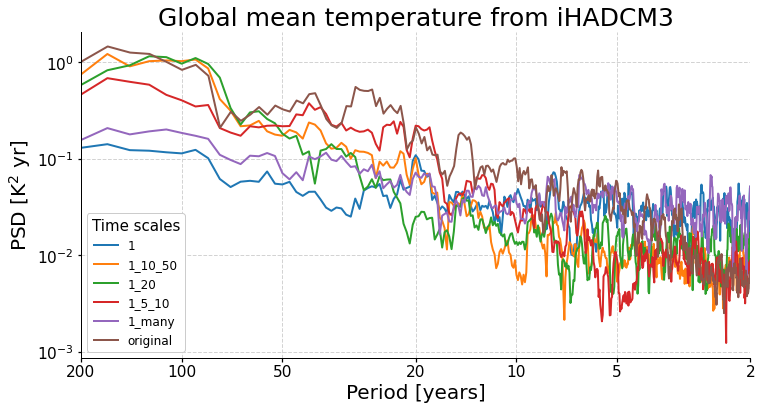

In [213]:
basepath='/home/mchoblet/paleoda/results/experiments/thesis_5_5_fields/'
model='iHadCM3'#'iHadCM3' #'Echam','GISS','isoGSM','iCESM'
resols=['1','1_10_50','1_20','1_5_10','1_many']

papath='iHADCM3_tsurf_801_1952.nc'#'ECHAM5_tsurf_850_1849.nc'
#iHADCM3_tsurf_801_1952.nc,GISS_tsurf_850_1849.nc,CESM_tsurf_850_1850.nc,CCSM_tsurf_851_1850.nc


original=xr.open_dataset(('/home/mchoblet/paleoda/data/model_data/'+papath))['tsurf']
original_ts=utils.globalmean(dataloader.annual_mean(original,check_nan=True).sel(time=slice('0850','1848')))

value=original_ts

fig,axes=plt.subplots(1,1,figsize=(12,6))
for r in resols:
    
    #try:
    
    data=xr.open_dataset(str(basepath+model+'_ts_'+r+'.nc'))
    method='mtm'
    #create py series # is label needed?
    py_ser=pyleo.Series(value=data['gm_tsurf'].values,time=np.arange(len(data['gm_tsurf'])),time_name='time',time_unit='year',label='other')
    test=py_ser.spectral(method=method,settings={'standardize':False})
    test.plot(ax=axes,label=r)
    """
    except:
        print(data['gm_tsurf'].values.shape)
        print(len(data['gm_tsurf']))
        import pdb
        pdb.set_trace()
    """     
        
py_ser=pyleo.Series(value=value.values,time=np.arange(len(value)),time_name='time',time_unit='year',label='other')
py_ser.spectral(method=method,settings={'standardize':False}).plot(ax=axes,label='original')
plt.legend(title='Time scales',fontsize=12,title_fontsize=15,frameon=True,framealpha=1)
plt.title('Global mean temperature from iHADCM3',fontsize=25)
plt.ylabel('PSD [K$^2$ yr]',fontsize=20)
plt.xlabel('Period [years]',fontsize=20)
plt.xlim(200,2)

In [207]:
fig.savefig('/home/mchoblet/plots_thesis/5_5/iHADCM3_spec.pdf', dpi='figure', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )

In [185]:
original.lat.values

array([ 90. ,  87.5,  85. ,  82.5,  80. ,  77.5,  75. ,  72.5,  70. ,
        67.5,  65. ,  62.5,  60. ,  57.5,  55. ,  52.5,  50. ,  47.5,
        45. ,  42.5,  40. ,  37.5,  35. ,  32.5,  30. ,  27.5,  25. ,
        22.5,  20. ,  17.5,  15. ,  12.5,  10. ,   7.5,   5. ,   2.5,
         0. ,  -2.5,  -5. ,  -7.5, -10. , -12.5, -15. , -17.5, -20. ,
       -22.5, -25. , -27.5, -30. , -32.5, -35. , -37.5, -40. , -42.5,
       -45. , -47.5, -50. , -52.5, -55. , -57.5, -60. , -62.5, -65. ,
       -67.5, -70. , -72.5, -75. , -77.5, -80. , -82.5, -85. , -87.5,
       -90. ], dtype=float32)

In [188]:
np.cos(np.deg2rad(87.5))

0.04361938736533601

Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year


KeyboardInterrupt: 

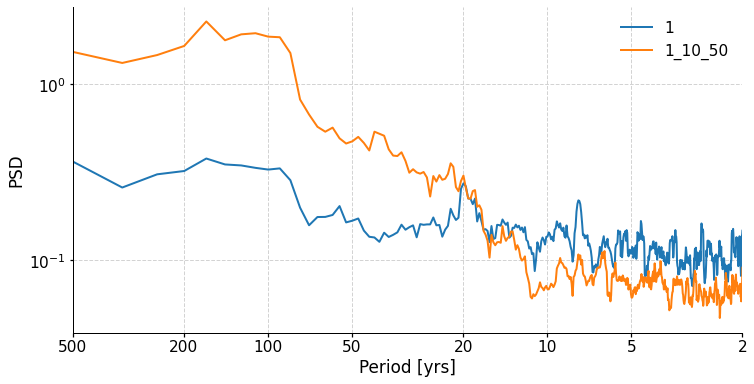

In [183]:
#try regional (#Here average weighting does not work that easily...)



basepath='/home/mchoblet/paleoda/results/experiments/thesis_5_5_fields/'
model='iHadCM3'#'iHadCM3' #'Echam','GISS','isoGSM','iCESM'
resols=['1','1_10_50','1_20','1_5_10','1_many']

papath='iHADCM3_tsurf_801_1952.nc'#'ECHAM5_tsurf_850_1849.nc'
#iHADCM3_tsurf_801_1952.nc,GISS_tsurf_850_1849.nc,CESM_tsurf_850_1850.nc,CCSM_tsurf_851_1850.nc


original=xr.open_dataset(('/home/mchoblet/paleoda/data/model_data/'+papath))['tsurf']
original_ts=dataloader.annual_mean(original,check_nan=True).sel(time=slice('0850','1848'))

land_110 = regionmask.defined_regions.natural_earth_v5_0_0.land_110
land_mask = land_110.mask_3D(original)
original_st=original_ts.stack(z=('lat','lon'))

fig_local,axes=plt.subplots(1,1,figsize=(12,6))
for r in resols:
    
    #try:
    
    data=xr.open_dataset(str(basepath+model+'_ts_'+r+'.nc'))['tsurf_mean'].stack(z=('lat','lon'))[:999]
    method='mtm'

    """
    except:
        print(data['gm_tsurf'].values.shape)
        print(len(data['gm_tsurf']))
        import pdb
        pdb.set_trace()
    """ 
    li=[]
    wgts=[]
    
    for z in data.z:
        lat=z.lat.values.tolist()
        lon=z.lon.values.tolist()
        if land_mask.sel(lat=lat,lon=lon)==True:
            py_ser=pyleo.Series(value=data.sel(z=z).values,time=np.arange(999),time_name='time',time_unit='year',label='other')
            test=py_ser.spectral(method=method,settings={'standardize':False})
            wgt=np.cos(np.deg2rad(lat))
            li.append(test.amplitude*wgt)
    freq=test.frequency
    amplitudes=np.mean(li,axis=0)
    test.amplitude=amplitudes
    test.frequency=freq
    test.plot(ax=axes,label=r)
    

li=[]
wgts=[]

for z in original_st.z:
    lat=z.lat.values.tolist()
    lon=z.lon.values.tolist()
    if land_mask.sel(lat=lat,lon=lon)==True:
        py_ser=pyleo.Series(value=original_st.sel(z=z).values,time=np.arange(999),time_name='time',time_unit='year',label='other')
        test=py_ser.spectral(method=method,settings={'standardize':False})
        wgt=np.cos(np.deg2rad(lat))
        li.append(test.amplitude*wgt)
        
freq=test.frequency
amplitudes=np.mean(li,axis=0)
test.amplitude=amplitudes
test.frequency=freq
test.plot(ax=axes,label='original')
plt.legend(title='Time scales',fontsize=12,title_fontsize=15,frameon=True,framealpha=1)
plt.title('Local land temperature from iHADCM3',fontsize=25)
#plt.xlim(200,2)

In [182]:
fig_local.savefig('/home/mchoblet/plots_thesis/5_5/iHADCM3_spec_local.pdf', dpi='figure', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )

Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year


(200.0, 2.0)

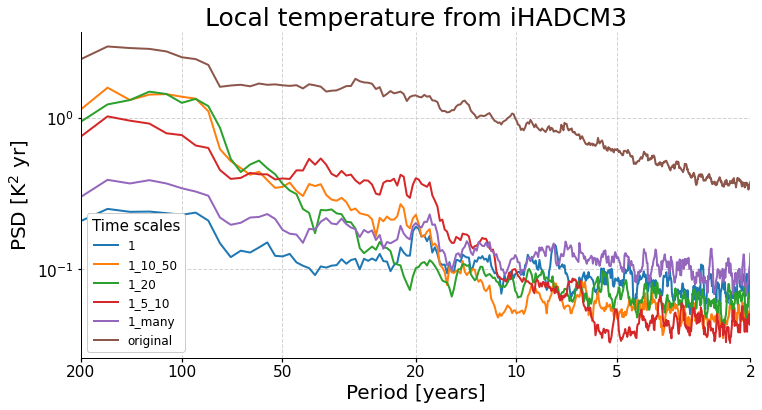

In [210]:
#try regional (everything, here average weighting is easy!

basepath='/home/mchoblet/paleoda/results/experiments/thesis_5_5_fields/'
model='iHadCM3'#'iHadCM3' #'Echam','GISS','isoGSM','iCESM'
resols=['1','1_10_50','1_20','1_5_10','1_many']

papath='iHADCM3_tsurf_801_1952.nc'#'ECHAM5_tsurf_850_1849.nc'
#iHADCM3_tsurf_801_1952.nc,GISS_tsurf_850_1849.nc,CESM_tsurf_850_1850.nc,CCSM_tsurf_851_1850.nc


original=xr.open_dataset(('/home/mchoblet/paleoda/data/model_data/'+papath))['tsurf']
original_ts=dataloader.annual_mean(original,check_nan=True).sel(time=slice('0850','1848'))
#weight=np.cos(np.deg2rad(original.lat)).sum().values

fig_local,axes=plt.subplots(1,1,figsize=(12,6))
for r in resols:
    
    #try:
    
    data=xr.open_dataset(str(basepath+model+'_ts_'+r+'.nc'))['tsurf_mean'].stack(z=('lat','lon'))[:999]
    method='mtm'

    """
    except:
        print(data['gm_tsurf'].values.shape)
        print(len(data['gm_tsurf']))
        import pdb
        pdb.set_trace()
    """ 
    li=[]
    for z in data.z:
        lat=z.lat.values.tolist()
        lon=z.lon.values.tolist()

        py_ser=pyleo.Series(value=data.sel(z=z).values,time=np.arange(999),time_name='time',time_unit='year',label='other')
        test=py_ser.spectral(method=method,settings={'standardize':False})
        li.append(test.amplitude*np.cos(np.deg2rad(lat)))
    freq=test.frequency
    amplitudes=np.mean(li,axis=0)
    test.amplitude=amplitudes
    test.frequency=freq
    test.plot(ax=axes,label=r)
    

li=[]
for z in original_st.z:
    lat=z.lat.values.tolist()
    lon=z.lon.values.tolist()

    py_ser=pyleo.Series(value=original_st.sel(z=z).values,time=np.arange(999),time_name='time',time_unit='year',label='other')
    test=py_ser.spectral(method=method,settings={'standardize':False})
    li.append(test.amplitude*np.cos(np.deg2rad(lat)))
freq=test.frequency
amplitudes=np.mean(li,axis=0)
test.amplitude=amplitudes
test.frequency=freq
test.plot(ax=axes,label='original')
plt.legend(title='Time scales',fontsize=12,title_fontsize=15,frameon=True,framealpha=1)
plt.title('Local temperature from iHADCM3',fontsize=25)
plt.ylabel('PSD [K$^2$ yr]',fontsize=20)
plt.xlabel('Period [years]',fontsize=20)
plt.xlim(200,2)


In [212]:
fig_local.savefig('/home/mchoblet/plots_thesis/5_5/iHADCM3_spec_local.pdf', dpi='figure', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )

In [71]:
xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_5_5/GISS_ts_1_many.nc')

<xarray.Dataset>
Dimensions:        (model: 1, reps: 10, nens: 100, site: 200, time: 1000,
                    bs: 1, time_res_1: 1000, site_1: 200)
Coordinates:
    MC_idx         (model, reps, nens) int64 ...
  * site           (site) object '0.235' '0.216' '0.228' ... '1.9' '1.33' '1.56'
  * time_res_1     (time_res_1) object 0850-01-01 00:00:00 ... 1849-01-01 00:...
  * site_1         (site_1) object '0.235' '0.216' '0.228' ... '1.33' '1.56'
Dimensions without coordinates: model, reps, nens, time, bs
Data variables: (12/15)
    HXf_m          (time, site) float64 ...
    HXf_std        (site) float64 ...
    HXf_prior_m    (bs, site) float64 ...
    HXf_prior_std  (bs, site) float64 ...
    gm_tsurf       (time) float64 ...
    gm_tsurf_std   (time) float64 ...
    ...             ...
    gm_prec_std    (time) float64 ...
    proxies_res_1  (time_res_1, site_1) float64 ...
    proxies        (time, site) float64 ...
    proxies_r      (time, site) float64 ...
    proxies_lat    (site) float64 ...
    proxies_lon    (site) float64 ...
Attributes:
    prior:    [{'long_name': 'H2O18 in Precip', 'units': 'per mil', 'grid_map...
    cfg:      {'vp': {'d18O': '/home/mchoblet/paleoda/data/model_data/GISS_d1...

In [69]:
bubu=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_5_5/iHadCM3_ts_1_many.nc')#['tsurf_mean']

In [ ]:
#mask landregions: https://regionmask.readthedocs.io/en/stable/defined_scientific.html#ar6-regions

#loop over non masked grid cells

#py_ser=pyleo.Series(value=value.values,time=np.arange(len(value)),time_name='time',time_unit='year',label='other')
#py_ser.spectral(method=method,settings={'standardize':False})

Checking prior for nans


(200.0, 2.0)

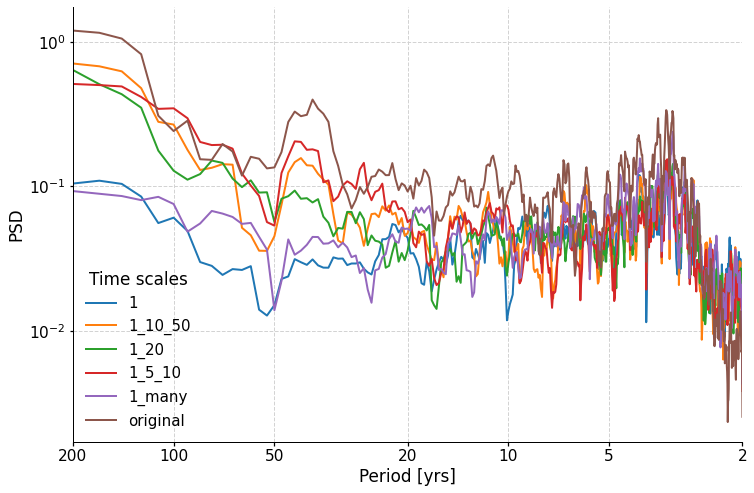

In [8]:
basepath='/home/mchoblet/paleoda/results/experiments/thesis_5_5/'
model='Echam'#'iHadCM3' #'Echam','GISS','isoGSM','iCESM'
resols=['1','1_10_50','1_20','1_5_10','1_many']
label

papath='iHADCM3_tsurf_801_1952.nc'#'ECHAM5_tsurf_850_1849.nc'
papath='ECHAM5_tsurf_850_1849.nc'

#iHADCM3_tsurf_801_1952.nc,GISS_tsurf_850_1849.nc,CESM_tsurf_850_1850.nc,CCSM_tsurf_851_1850.nc


original=xr.open_dataset(('/home/mchoblet/paleoda/data/model_data/'+papath))['tsurf']
original_ts=utils.globalmean(dataloader.annual_mean(original,check_nan=True).sel(time=slice('0850','1849')))

value=original_ts

fig,axes=plt.subplots(1,1,figsize=(12,8))
for i,r in enumerate(resols):
    data=xr.open_dataset(str(basepath+model+'_ts_'+r+'.nc'))
    method='mtm'
    
    time=np.arange(1000)
    #create py series # is label needed?
    py_ser=pyleo.Series(value=data['gm_tsurf'].values,time=time,time_name='time',time_unit='year',label='other')
    py_ser.spectral(method=method,settings={'standardize':False}).plot(ax=axes,label=r)


py_ser=pyleo.Series(value=value.values,time=np.arange(len(value)),time_name='time',time_unit='year',label='other')
py_ser.spectral(method=method,settings={'standardize':False}).plot(ax=axes,label='Original')
plt.legend(title='Time scales',fontsize=15)
plt.xlim(200,2)

Checking prior for nans


Text(0.5, 1.0, 'Local land temperature from ECHAM')

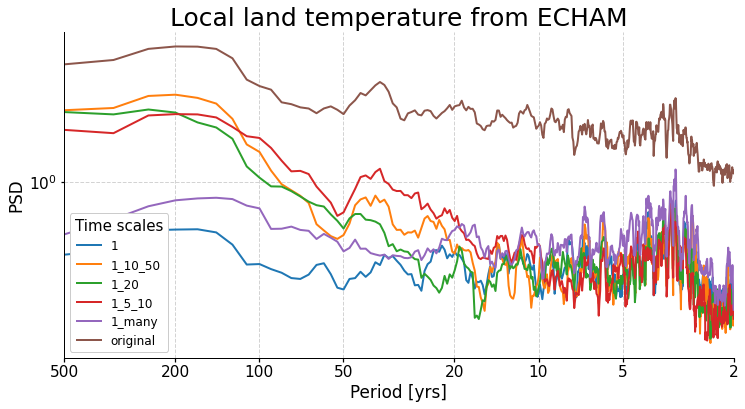

In [175]:
basepath='/home/mchoblet/paleoda/results/experiments/thesis_5_5_fields/'
model='Echam'#'iHadCM3' #'Echam','GISS','isoGSM','iCESM'
resols=['1','1_10_50','1_20','1_5_10','1_many']

papath='ECHAM5_tsurf_850_1849.nc'


original=xr.open_dataset(('/home/mchoblet/paleoda/data/model_data/'+papath))['tsurf']
original_ts=dataloader.annual_mean(original,check_nan=True).sel(time=slice('0850','1848'))

land_110 = regionmask.defined_regions.natural_earth_v5_0_0.land_110
land_mask = land_110.mask_3D(original)
original_st=original_ts.stack(z=('lat','lon'))

fig_local2,axes=plt.subplots(1,1,figsize=(12,6))
for r in resols:
    
    #try:
    
    data=xr.open_dataset(str(basepath+model+'_ts_'+r+'.nc'))['tsurf_mean'].stack(z=('lat','lon'))[:999]
    method='mtm'

    """
    except:
        print(data['gm_tsurf'].values.shape)
        print(len(data['gm_tsurf']))
        import pdb
        pdb.set_trace()
    """ 
    li=[]
    for z in data.z:
        lat=z.lat.values.tolist()
        lon=z.lon.values.tolist()
        if land_mask.sel(lat=lat,lon=lon)==True:
            py_ser=pyleo.Series(value=data.sel(z=z).values,time=np.arange(999),time_name='time',time_unit='year',label='other')
            test=py_ser.spectral(method=method,settings={'standardize':False})
            li.append(test.amplitude)
    freq=test.frequency
    amplitudes=np.mean(li,axis=0)
    test.amplitude=amplitudes
    test.frequency=freq
    test.plot(ax=axes,label=r)
    

li=[]
for z in original_st.z:
    lat=z.lat.values.tolist()
    lon=z.lon.values.tolist()
    if land_mask.sel(lat=lat,lon=lon)==True:
        py_ser=pyleo.Series(value=original_st.sel(z=z).values,time=np.arange(999),time_name='time',time_unit='year',label='other')
        test=py_ser.spectral(method=method,settings={'standardize':False})
        li.append(test.amplitude)
freq=test.frequency
amplitudes=np.mean(li,axis=0)
test.amplitude=amplitudes
test.frequency=freq
test.plot(ax=axes,label='original')
plt.legend(title='Time scales',fontsize=12,title_fontsize=15,frameon=True,framealpha=1)
plt.title('Local land temperature from ECHAM',fontsize=25)

Checking prior for nans


(200.0, 2.0)

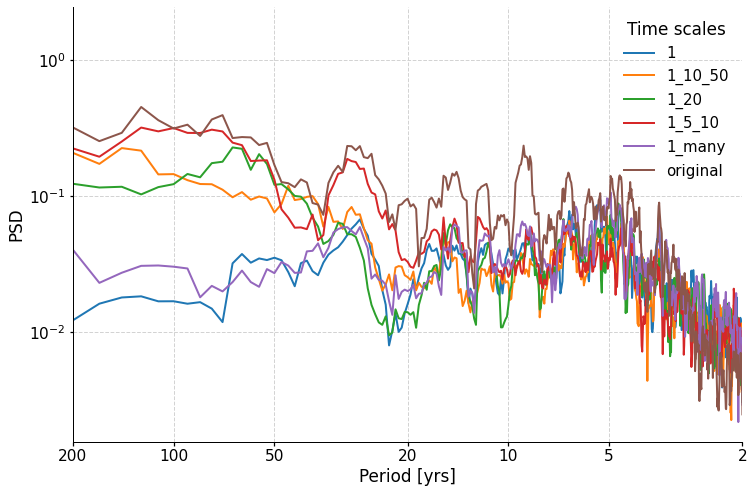

In [9]:
basepath='/home/mchoblet/paleoda/results/experiments/thesis_5_5/'
model='iCESM'#'Echam'#'iHadCM3' #'Echam','GISS','isoGSM','iCESM'
resols=['1','1_10_50','1_20','1_5_10','1_many']

papath='iHADCM3_tsurf_801_1952.nc'#'ECHAM5_tsurf_850_1849.nc'
papath='CESM_tsurf_850_1850.nc'

#iHADCM3_tsurf_801_1952.nc,GISS_tsurf_850_1849.nc,CESM_tsurf_850_1850.nc,CCSM_tsurf_851_1850.nc


original=xr.open_dataset(('/home/mchoblet/paleoda/data/model_data/'+papath))['tsurf']
original_ts=utils.globalmean(dataloader.annual_mean(original,check_nan=True).sel(time=slice('0850','1849')))

value=original_ts

fig,axes=plt.subplots(1,1,figsize=(12,8))
for r in resols:
    data=xr.open_dataset(str(basepath+model+'_ts_'+r+'.nc'))
    method='mtm'
    
    time=np.arange(1000)
    #create py series # is label needed?
    py_ser=pyleo.Series(value=data['gm_tsurf'].values,time=time,time_name='time',time_unit='year',label='other')
    py_ser.spectral(method=method,settings={'standardize':False}).plot(ax=axes,label=r)


py_ser=pyleo.Series(value=value.values,time=np.arange(len(value)),time_name='time',time_unit='year',label='other')
py_ser.spectral(method=method,settings={'standardize':False}).plot(ax=axes,label='original')
plt.legend(title='Time scales',fontsize=15)
plt.xlim(200,2)

Checking prior for nans


Text(0.5, 1.0, 'Local land temperature from iCESM')

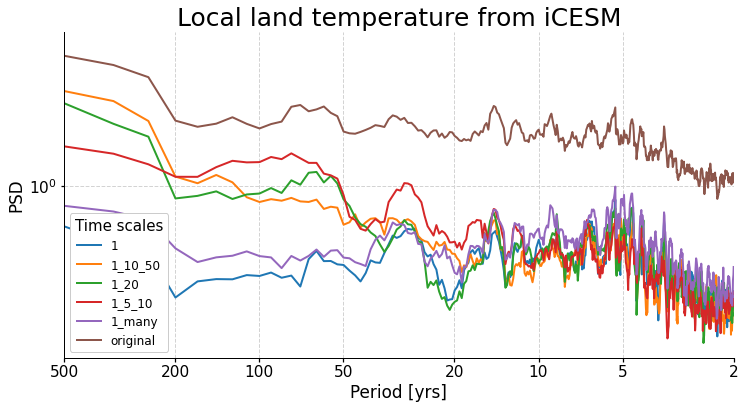

In [176]:
basepath='/home/mchoblet/paleoda/results/experiments/thesis_5_5_fields/'
model='iCESM'#'Echam'#'iHadCM3' #'Echam','GISS','isoGSM','iCESM'
resols=['1','1_10_50','1_20','1_5_10','1_many']

papath='CESM_tsurf_850_1850.nc'


original=xr.open_dataset(('/home/mchoblet/paleoda/data/model_data/'+papath))['tsurf']
original_ts=dataloader.annual_mean(original,check_nan=True).sel(time=slice('0850','1848'))

land_110 = regionmask.defined_regions.natural_earth_v5_0_0.land_110
land_mask = land_110.mask_3D(original)
original_st=original_ts.stack(z=('lat','lon'))

fig_local3,axes=plt.subplots(1,1,figsize=(12,6))
for r in resols:
    
    #try:
    
    data=xr.open_dataset(str(basepath+model+'_ts_'+r+'.nc'))['tsurf_mean'].stack(z=('lat','lon'))[:999]
    method='mtm'

    """
    except:
        print(data['gm_tsurf'].values.shape)
        print(len(data['gm_tsurf']))
        import pdb
        pdb.set_trace()
    """ 
    li=[]
    for z in data.z:
        lat=z.lat.values.tolist()
        lon=z.lon.values.tolist()
        if land_mask.sel(lat=lat,lon=lon)==True:
            py_ser=pyleo.Series(value=data.sel(z=z).values,time=np.arange(999),time_name='time',time_unit='year',label='other')
            test=py_ser.spectral(method=method,settings={'standardize':False})
            li.append(test.amplitude)
    freq=test.frequency
    amplitudes=np.mean(li,axis=0)
    test.amplitude=amplitudes
    test.frequency=freq
    test.plot(ax=axes,label=r)
    

li=[]
for z in original_st.z:
    lat=z.lat.values.tolist()
    lon=z.lon.values.tolist()
    if land_mask.sel(lat=lat,lon=lon)==True:
        py_ser=pyleo.Series(value=original_st.sel(z=z).values,time=np.arange(999),time_name='time',time_unit='year',label='other')
        test=py_ser.spectral(method=method,settings={'standardize':False})
        li.append(test.amplitude)
freq=test.frequency
amplitudes=np.mean(li,axis=0)
test.amplitude=amplitudes
test.frequency=freq
test.plot(ax=axes,label='original')
plt.legend(title='Time scales',fontsize=12,title_fontsize=15,frameon=True,framealpha=1)
plt.title('Local land temperature from iCESM',fontsize=25)

Checking prior for nans


(200.0, 2.0)

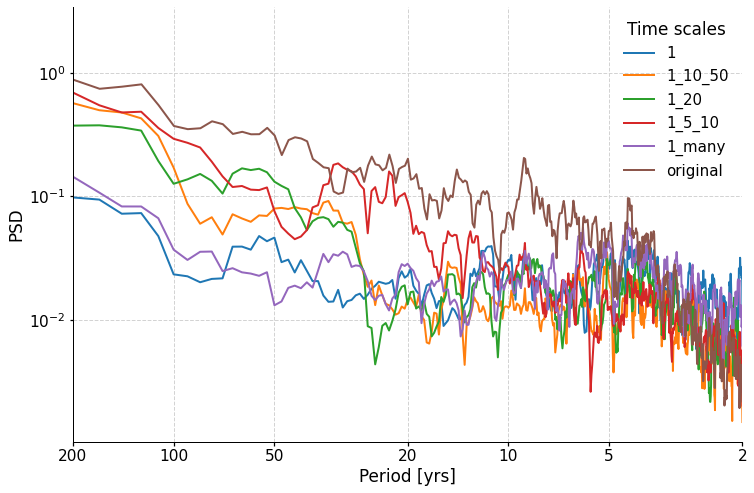

In [10]:
basepath='/home/mchoblet/paleoda/results/experiments/thesis_5_5/'
model='isoGSM'#'Echam'#'iHadCM3' #'Echam','GISS','isoGSM','iCESM'
resols=['1','1_10_50','1_20','1_5_10','1_many']

#papath='iHADCM3_tsurf_801_1952.nc'#'ECHAM5_tsurf_850_1849.nc'
papath='CCSM_tsurf_851_1850.nc'

#iHADCM3_tsurf_801_1952.nc,GISS_tsurf_850_1849.nc,CESM_tsurf_850_1850.nc,CCSM_tsurf_851_1850.nc


original=xr.open_dataset(('/home/mchoblet/paleoda/data/model_data/'+papath))['tsurf']
original_ts=utils.globalmean(dataloader.annual_mean(original,check_nan=True).sel(time=slice('0850','1849')))

value=original_ts

fig,axes=plt.subplots(1,1,figsize=(12,8))
for r in resols:
    data=xr.open_dataset(str(basepath+model+'_ts_'+r+'.nc'))
    method='mtm'
    
    time=np.arange(1000)
    #create py series # is label needed?
    py_ser=pyleo.Series(value=data['gm_tsurf'].values,time=time,time_name='time',time_unit='year',label='other')
    py_ser.spectral(method=method,settings={'standardize':False}).plot(ax=axes,label=r)


py_ser=pyleo.Series(value=value.values,time=np.arange(len(value)),time_name='time',time_unit='year',label='other')
py_ser.spectral(method=method,settings={'standardize':False}).plot(ax=axes,label='original')
plt.legend(title='Time scales',fontsize=15)
plt.xlim(200,2)

Checking prior for nans


Text(0.5, 1.0, 'Local land temperature from isoGSM')

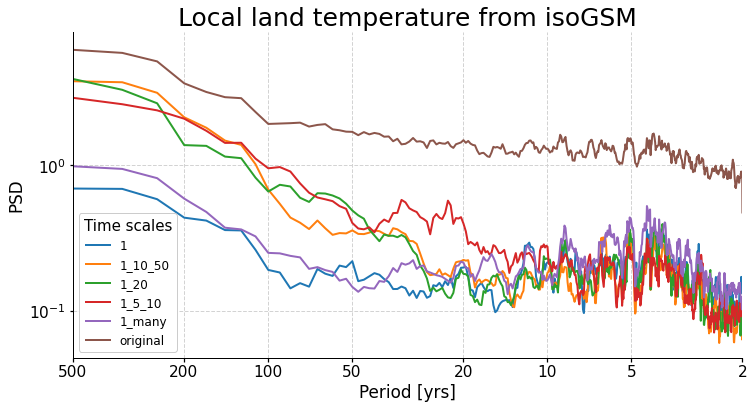

In [179]:
basepath='/home/mchoblet/paleoda/results/experiments/thesis_5_5_fields/'
model='isoGSM'#'Echam'#'iHadCM3' #'Echam','GISS','isoGSM','iCESM'
resols=['1','1_10_50','1_20','1_5_10','1_many']

papath='CCSM_tsurf_851_1850.nc'

original=xr.open_dataset(('/home/mchoblet/paleoda/data/model_data/'+papath))['tsurf']
original_ts=dataloader.annual_mean(original,check_nan=True).sel(time=slice('0850','1848'))

land_110 = regionmask.defined_regions.natural_earth_v5_0_0.land_110
land_mask = land_110.mask_3D(original)
original_st=original_ts.stack(z=('lat','lon'))

fig_local4,axes=plt.subplots(1,1,figsize=(12,6))
for r in resols:
    
    #try:
    
    data=xr.open_dataset(str(basepath+model+'_ts_'+r+'.nc'))['tsurf_mean'].stack(z=('lat','lon'))[:999]
    method='mtm'

    """
    except:
        print(data['gm_tsurf'].values.shape)
        print(len(data['gm_tsurf']))
        import pdb
        pdb.set_trace()
    """ 
    li=[]
    for z in data.z:
        lat=z.lat.values.tolist()
        lon=z.lon.values.tolist()
        if land_mask.sel(lat=lat,lon=lon)==True:
            py_ser=pyleo.Series(value=data.sel(z=z).values,time=np.arange(999),time_name='time',time_unit='year',label='other')
            test=py_ser.spectral(method=method,settings={'standardize':False})
            li.append(test.amplitude)
    freq=test.frequency
    amplitudes=np.mean(li,axis=0)
    test.amplitude=amplitudes
    test.frequency=freq
    test.plot(ax=axes,label=r)
    

li=[]
for z in original_st.z:
    lat=z.lat.values.tolist()
    lon=z.lon.values.tolist()
    if land_mask.sel(lat=lat,lon=lon)==True:
        py_ser=pyleo.Series(value=original_st.sel(z=z).values,time=np.arange(998),time_name='time',time_unit='year',label='other')
        test=py_ser.spectral(method=method,settings={'standardize':False})
        li.append(test.amplitude)
freq=test.frequency
amplitudes=np.mean(li,axis=0)
test.amplitude=amplitudes
test.frequency=freq
test.plot(ax=axes,label='original')
plt.legend(title='Time scales',fontsize=12,title_fontsize=15,frameon=True,framealpha=1)
plt.title('Local land temperature from isoGSM',fontsize=25)

Checking prior for nans


(200.0, 2.0)

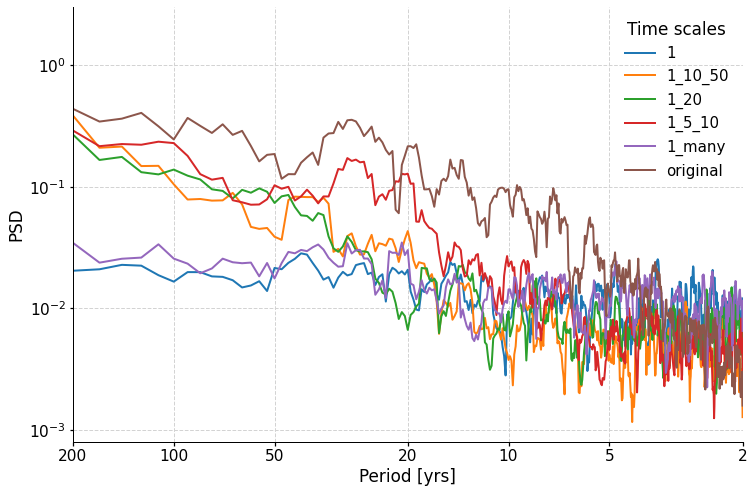

In [13]:
basepath='/home/mchoblet/paleoda/results/experiments/thesis_5_5/'
model='GISS'#'Echam'#'iHadCM3' #'Echam','GISS','isoGSM','iCESM'
resols=['1','1_10_50','1_20','1_5_10','1_many']

#papath='iHADCM3_tsurf_801_1952.nc'#'ECHAM5_tsurf_850_1849.nc'
papath='GISS_tsurf_850_1849.nc'

#iHADCM3_tsurf_801_1952.nc,GISS_tsurf_850_1849.nc,CESM_tsurf_850_1850.nc,CCSM_tsurf_851_1850.nc


original=xr.open_dataset(('/home/mchoblet/paleoda/data/model_data/'+papath))['tsurf']
original_ts=utils.globalmean(dataloader.annual_mean(original,check_nan=True).sel(time=slice('0850','1849')))

value=original_ts

fig,axes=plt.subplots(1,1,figsize=(12,8))
for r in resols:
    data=xr.open_dataset(str(basepath+model+'_ts_'+r+'.nc'))
    method='mtm'
    
    time=np.arange(1000)
    #create py series # is label needed?
    py_ser=pyleo.Series(value=data['gm_tsurf'].values,time=time,time_name='time',time_unit='year',label='other')
    py_ser.spectral(method=method,settings={'standardize':False}).plot(ax=axes,label=r)


py_ser=pyleo.Series(value=value.values,time=np.arange(len(value)),time_name='time',time_unit='year',label='other')
py_ser.spectral(method=method,settings={'standardize':False}).plot(ax=axes,label='original')
plt.legend(title='Time scales',fontsize=15)
plt.xlim(200,2)

Checking prior for nans


Text(0.5, 1.0, 'Local land temperature from GISS')

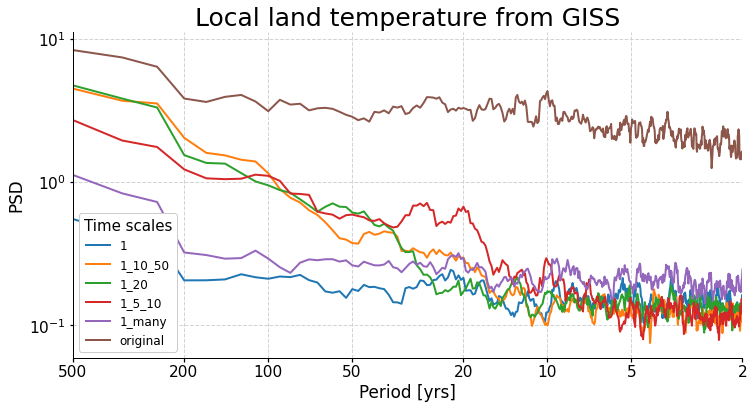

In [180]:
basepath='/home/mchoblet/paleoda/results/experiments/thesis_5_5_fields/'
model='GISS'#'Echam'#'iHadCM3' #'Echam','GISS','isoGSM','iCESM'
resols=['1','1_10_50','1_20','1_5_10','1_many']

papath='GISS_tsurf_850_1849.nc'

original=xr.open_dataset(('/home/mchoblet/paleoda/data/model_data/'+papath))['tsurf']
original_ts=dataloader.annual_mean(original,check_nan=True).sel(time=slice('0850','1848'))

land_110 = regionmask.defined_regions.natural_earth_v5_0_0.land_110
land_mask = land_110.mask_3D(original)
original_st=original_ts.stack(z=('lat','lon'))

fig_local4,axes=plt.subplots(1,1,figsize=(12,6))
for r in resols:
    
    #try:
    
    data=xr.open_dataset(str(basepath+model+'_ts_'+r+'.nc'))['tsurf_mean'].stack(z=('lat','lon'))[:999]
    method='mtm'

    """
    except:
        print(data['gm_tsurf'].values.shape)
        print(len(data['gm_tsurf']))
        import pdb
        pdb.set_trace()
    """ 
    li=[]
    for z in data.z:
        lat=z.lat.values.tolist()
        lon=z.lon.values.tolist()
        if land_mask.sel(lat=lat,lon=lon)==True:
            py_ser=pyleo.Series(value=data.sel(z=z).values,time=np.arange(999),time_name='time',time_unit='year',label='other')
            test=py_ser.spectral(method=method,settings={'standardize':False})
            li.append(test.amplitude)
    freq=test.frequency
    amplitudes=np.mean(li,axis=0)
    test.amplitude=amplitudes
    test.frequency=freq
    test.plot(ax=axes,label=r)
    

li=[]
for z in original_st.z:
    lat=z.lat.values.tolist()
    lon=z.lon.values.tolist()
    if land_mask.sel(lat=lat,lon=lon)==True:
        py_ser=pyleo.Series(value=original_st.sel(z=z).values,time=np.arange(999),time_name='time',time_unit='year',label='other')
        test=py_ser.spectral(method=method,settings={'standardize':False})
        li.append(test.amplitude)
freq=test.frequency
amplitudes=np.mean(li,axis=0)
test.amplitude=amplitudes
test.frequency=freq
test.plot(ax=axes,label='original')
plt.legend(title='Time scales',fontsize=12,title_fontsize=15,frameon=True,framealpha=1)
plt.title('Local land temperature from GISS',fontsize=25)

In [16]:
results_1=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_5_5/iHadCM3_ts_1.nc')
results_1_5=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_5_5/iHadCM3_ts_1_5.nc')
results_1_10_20=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_5_5/iHadCM3_ts_1_10_20.nc')
results_1_5_20=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_5_5/iHadCM3_ts_1_5_20.nc')
#results_1_10=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_5_5/iHadCM3_ts_1_10.nc')
results_1_many=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_5_5/iHadCM3_ts_1_many.nc')

#results_1['time']=results_1['time_res_1']
#results_1_5['time']=results_1['time_res_1']
#results_1_5_20['time']=results_1['time_res_1']
#results_1_10_20['time']=results_1['time_res_1']

#results_1_10['time']=results_1['time_res_1']

In [22]:
original=xr.open_dataset('/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc')['tsurf']
original_ts=utils.globalmean(dataloader.annual_mean(original,check_nan=True).sel(time=slice('0850','1849')))

Checking prior for nans


In [23]:
import pyleoclim as pyleo
from matplotlib import ticker
import matplotlib
import scipy

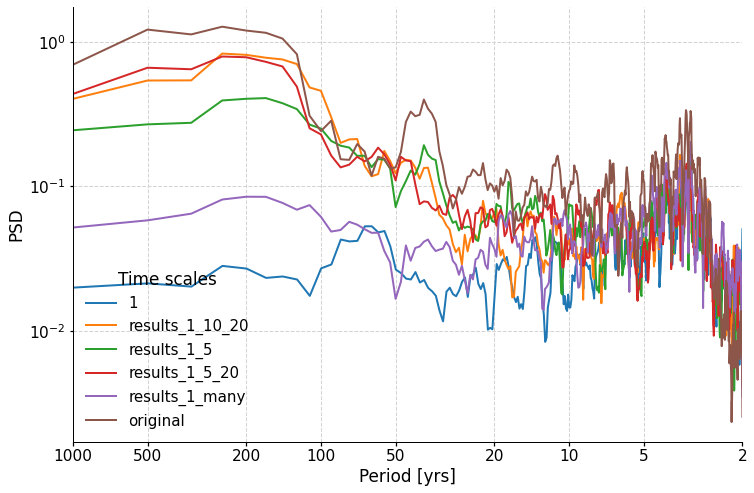

In [42]:


labels=['1','results_1_10_20','results_1_5','results_1_5_20','results_1_many']
start=850;
#end=1849
end=1848
method='mtm'
fig,axes=plt.subplots(1,1,figsize=(12,8))
for i,p in enumerate([results_1,results_1_10_20,results_1_5,results_1_5_20,results_1_many]):    
    time=np.arange(1000)
    #create py series # is label needed?
    py_ser=pyleo.Series(value=p['gm_tsurf'].values,time=time,time_name='time',time_unit='year',label='other')
    py_ser.spectral(method=method,settings={'standardize':False}).plot(ax=axes,label=labels[i])

value=original_ts
py_ser=pyleo.Series(value=value.values,time=np.arange(len(value)),time_name='time',time_unit='year',label='other')
py_ser.spectral(method=method,settings={'standardize':False}).plot(ax=axes,label='original')
plt.legend(title='Time scales',fontsize=15)